In [19]:
import regex as re
import numpy as np
import matplotlib.pyplot as plt

In [20]:
input_file = "input.py"

with open(input_file) as f:
    text = f.read()

print(text)

import json as jorre

y = 9.77
x = [37, 2]
for k in range(x[0]):
    print("öh" * k)

this_variable = "hej på dig"

a_longer123string = this_variable + "ööhö"



In [21]:
def tokenize(text) -> list[str]:
    """Tokenize a text"""
    # Possible string delimiters
    string_delims = {'"', "'", '"""', "'''"}

    # split everything
    tokens = re.findall(r"(\w+|[^\w\s]+|\s+|\n)", text)

    ## split tokens without letters or numbers or repeated operators
    tmp = []
    for t in tokens:
        if bool(re.search(r"\p{L}|\p{digit}", t)):
            tmp.append(t)
        elif len(t) > 1 and all((c == t[0] for c in t)):
            tmp.append(t)
        else:
            tmp.extend(list(t))

    tokens = tmp

    ## reunite string literals and (decimal) numbers
    tmp = []
    tags = []
    current_delim = ""
    current_string = ""
    for i, t in enumerate(tokens):
        if current_delim == "":
            if t in string_delims:
                # start a string
                current_delim = t
                current_string += t
            else:
                tmp.append(t)
                tags.append("<unk>")
        else:
            if t == current_delim:
                # break current string
                current_delim = ""
                current_string += t
                tmp.append(current_string)
                tags.append("str")
                current_string = ""
            else:
                # add to current string
                current_string += t

    tokens = tmp

    # tmp = []
    # tmp_tags = []
    # ## reunite decimal numbers
    # for i in range(len(tokens) - 1):
    #     t = tokens[i]
    #     t2 = tokens[i]
    #     if (t.isdigit() or t == ".") and t2.isdigit():
    #         tmp.append(t)

    return tokens, tags


tokens, tags = tokenize(text)
print(tokens)

['import', ' ', 'json', ' ', 'as', ' ', 'jorre', '\n\n', 'y', ' ', '=', ' ', '9', '.', '77', '\n', 'x', ' ', '=', ' ', '[', '37', ',', ' ', '2', ']', '\n', 'for', ' ', 'k', ' ', 'in', ' ', 'range', '(', 'x', '[', '0', ']', ')', ':', '\n', ' ', ' ', ' ', ' ', 'print', '(', '"öh"', ' ', '*', ' ', 'k', ')', '\n\n', 'this_variable', ' ', '=', ' ', '"hej på dig"', '\n\n', 'a_longer123string', ' ', '=', ' ', 'this_variable', ' ', '+', ' ', '"ööhö"', '\n']


## tagging

In [22]:
print("# tokens", len(tokens))

known_chars = {
    "op": r"=!%&/+-*:",
    "brac_op": r"([{",
    "brac_cl": r")]}",
}

# first: tag individual tokens

for i, token in enumerate(tokens):
    if token.isdigit():
        tags[i] = "num"
        continue
    elif not bool(re.search("[^\s]", token)):
        tags[i] = "wsp"

    for key in known_chars.keys():
        if token in known_chars[key]:
            tags[i] = key
            break


# print
for i, x in enumerate(zip(tags, tokens)):
    if x[0] != "<unk>" and x[0] != "wsp":
        print(i, x[0], repr(x[1]))

# second: tag based on context

# tokens 71
10 op '='
12 num '9'
14 num '77'
18 op '='
20 brac_op '['
21 num '37'
24 num '2'
25 brac_cl ']'
34 brac_op '('
36 brac_op '['
37 num '0'
38 brac_cl ']'
39 brac_cl ')'
40 op ':'
47 brac_op '('
48 str '"öh"'
50 op '*'
53 brac_cl ')'
57 op '='
59 str '"hej på dig"'
63 op '='
67 op '+'
69 str '"ööhö"'


In [23]:
for x in zip(tags, tokens):
    if x[0] == "<unk>":
        print("\t".join(x))

for x in zip(tags, tokens):
    if x[0] == "wsp":
        print(repr(x[1]), end=";")

<unk>	import
<unk>	json
<unk>	as
<unk>	jorre
<unk>	y
<unk>	.
<unk>	x
<unk>	,
<unk>	for
<unk>	k
<unk>	in
<unk>	range
<unk>	x
<unk>	print
<unk>	k
<unk>	this_variable
<unk>	a_longer123string
<unk>	this_variable
' ';' ';' ';'\n\n';' ';' ';'\n';' ';' ';' ';'\n';' ';' ';' ';'\n';' ';' ';' ';' ';' ';' ';'\n\n';' ';' ';'\n\n';' ';' ';' ';' ';'\n';

## features

In [24]:
feature_names = (
    "in_()",
    "in_[],",
    "before_.",
    "after_.",
    "before_(",
    "before_[",
    "before_op",
    "after_op",
)

### bracket level

In [25]:
brac_level = {"()": [], "[]": [], "{}": []}
current_level = {"()": 0, "[]": 0, "{}": 0}
for token, tag in zip(tokens, tags):
    if tag == "brac_op":
        for k in current_level.keys():
            brac_level[k].append(current_level[k])
            if token in k:
                current_level[k] += 1
    elif tag == "brac_cl":
        for k in current_level.keys():
            if token in k:
                current_level[k] -= 1
            brac_level[k].append(current_level[k])
    else:
        for k in current_level.keys():
            brac_level[k].append(current_level[k])

feature matrix (71, 8)
(0, 'in_()') (1, 'in_[],') (2, 'before_.') (3, 'after_.') (4, 'before_(') (5, 'before_[') (6, 'before_op') (7, 'after_op')


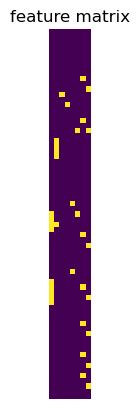

In [26]:
features = np.zeros((len(tokens), len(feature_names)))

print("feature matrix", features.shape)
print(*zip(range(len(feature_names)), feature_names))

# in brackets?
features[:, 0] = np.array(brac_level["()"])
features[:, 1] = np.array(brac_level["[]"])

# before and after?
for i, token in enumerate(tokens):
    if token == ".":
        if i > 0:
            features[i - 1, 2] = 1
        if i < len(tokens) - 1:
            features[i + 1, 3] = 1

    if token == "(":
        if i > 0:
            features[i - 1, 4] = 1

    if token == "[":
        if i > 0:
            features[i - 1, 5] = 1

    if tags[i] == "op":
        if i > 0:
            features[i - 1, 6] = 1
        if i < len(tokens) - 1:
            features[i + 1, 7] = 1


plt.figure()
plt.imshow(features)
plt.axis("off")
plt.title("feature matrix")
plt.show()

## classify

(71, 2)


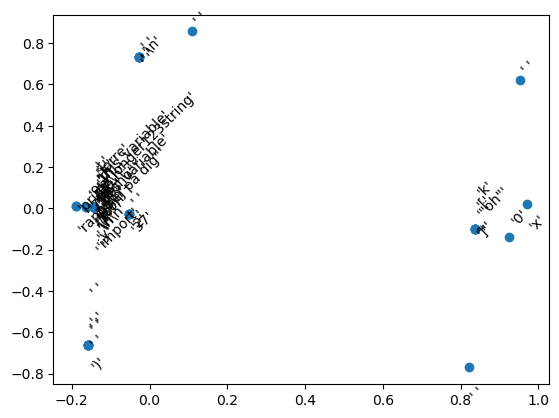

In [30]:
from sklearn.decomposition import PCA

rng = np.random.default_rng()
pca = PCA(n_components=2)

f_PCA = pca.fit_transform(features)
print(f_PCA.shape)

plt.figure()
plt.scatter(x=f_PCA[:, 0], y=f_PCA[:, 1])
for i, t in enumerate(tokens):
    plt.text(x=f_PCA[i, 0], y=f_PCA[i, 1] + 0.1 * rng.normal(), s=repr(t), rotation=45)


## HTML cleanup

In [28]:
text = "".join(tokens)

text = re.sub(r"  ", r"&nbsp; ", text)
text = re.sub(r"\n", r"<br>\n", text)
print(text)

import json as jorre<br>
<br>
y = 9.77<br>
x = [37, 2]<br>
for k in range(x[0]):<br>
&nbsp; &nbsp; print("öh" * k)<br>
<br>
this_variable = "hej på dig"<br>
<br>
a_longer123string = this_variable + "ööhö"<br>

